# Generating ROC Curves

In [119]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *
from analysis import *

R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t / Nsamp # noise variance single channel, freq-domain (tau_1f)

# Generate example distributions
def calculate_signal_dists(vals, tau, loc, FFT_peaks, Nsamp):

    rice_cdf = np.ones(len(vals))
    for peak in FFT_peaks:
        rice_cdf *= scipy.stats.rice.cdf(vals, b=abs(peak)/np.sqrt(tau/2), loc=loc, scale=np.sqrt(tau/2))
            
    cdf = rice_cdf * (1-np.exp(-(vals**2)/tau)) ** (Nsamp-FFT_peaks.size)

    pdf = np.gradient(cdf, vals[1]-vals[0])
    
    return cdf, pdf
    
def calculate_noise_dists(vals, tau, Nsamp):
    ray_cdf = (1-np.exp(-(vals**2)/tau)) ** Nsamp
    ray_pdf = np.gradient(ray_cdf, vals[1]-vals[0])
    
    return ray_cdf, ray_pdf



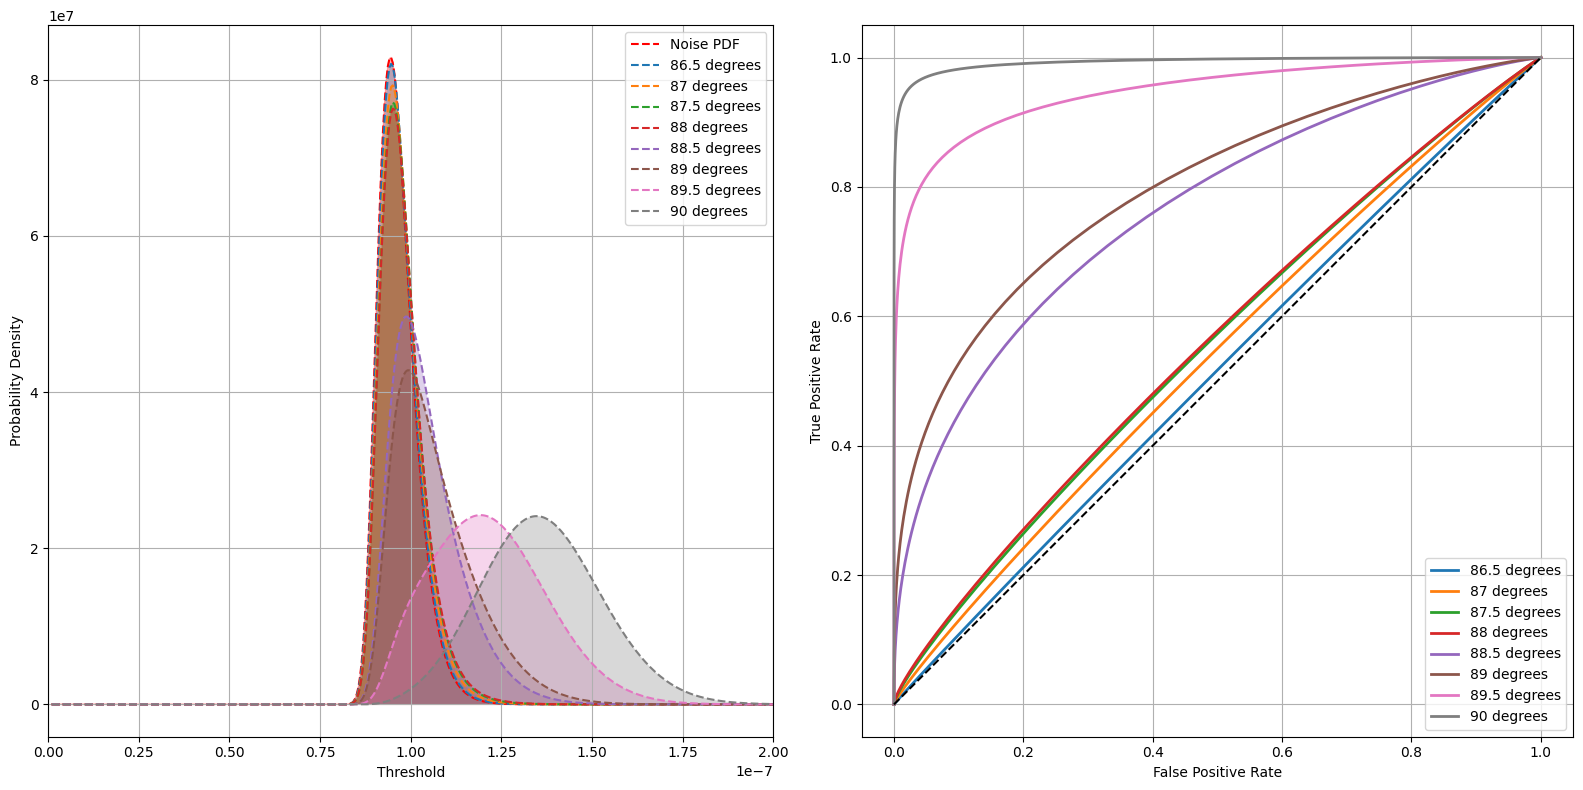

In [120]:
from scipy import stats

threshold = np.linspace(1e-9, 9e-6, 20001)
x = threshold

noise_pdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[1]
# signal_pdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[1]
# signal86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[1]

# Calculate CDFs
noise_cdf = calculate_noise_dists(threshold, tau_1f, Nsamp)[0]
# signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, peaks, Nsamp)[0]
# signal_cdf86p5 = calculate_signal_dists(threshold, tau_1f, 0, peaks1, Nsamp)[0]

# Calculate ROC points (FPR = 1-specificity, TPR = sensitivity)
fpr = 1 - noise_cdf  # false positive rate


file_list = [
    'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5', 
    'harmonic/87deg/out_0a5c4e19-2fc3-4f5c-9090-8d2cce62ae19.h5', 
    'harmonic/87p5deg/out_0c7fdf39-0ea3-4c84-9a9d-60c68b480bb1.h5', 
    'harmonic/88deg/out_0ad74f8f-ec02-44f5-a5af-5c69bef4774e.h5',
    'harmonic/88p5deg/out_0a1bc7f8-6e25-47f3-9743-f404227c3d0b.h5',
    'harmonic/89deg/out_1a0ad631-1153-47ef-8cba-ea9ab0cefa3d.h5',
    'harmonic/89p5deg/out_51db499d-c8ea-4cce-884b-d9c3e3f44ed1.h5',
    'harmonic/90deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5']

harmonic_angles = ['86.5', '87', '87.5', '88', '88.5', '89','89.5', '90']

# Plot distributions and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot PDFs
ax1.plot(threshold, noise_pdf, 'r--', label='Noise PDF')
ax1.fill_between(threshold, noise_pdf, alpha=0.3, color='red')

aucs = []

for i, file_name in enumerate(file_list):

    # signal_strings, attributes, attrs_container = get_attributes(file_name)
    signal = get_signal(file_name, 'signal1') # One polarisation
    signal_FFT = np.fft.fft(signal, norm='forward')

    # signal_maximums = signal_FFT[signal_FFT > 1e-8]
    # peaks = np.array(signal_maximums)
    
    # print(peaks)
    
    # signal_max_index = np.argmax(abs(signal_FFT))
    # complex_signal_max = signal_FFT[signal_max_index]

    pks = get_signal_peaks(signal, 1e-8)
    
    # print(peaks)

    rice_cdf = np.ones(20001)
    for peak in pks:
        rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
        
    signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

    signal_pdf = np.gradient(signal_cdf, x[1]-x[0])


    tpr = 1 - signal_cdf  # true positive rate

    signal_label = str(harmonic_angles[i]) + ' degrees'
    
    ax1.plot(threshold, signal_pdf, '--', label=signal_label)
    ax1.fill_between(threshold, signal_pdf, alpha=0.3)
    # Plot ROC curve
    
    roc_label = str(harmonic_angles[i]) + ' degrees'
    
    ax2.plot(fpr, tpr, '-', linewidth=2, label=roc_label) 
    auc = abs(np.trapz(tpr, fpr))
    aucs.append(auc)


ax1.set_xlabel('Threshold')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.set_xlim(0, 0.2e-6)
ax1.grid(True)


ax2.plot([0, 1], [0, 1], 'k--')  # random guess line
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.savefig('harmonic_roc.png')
plt.show()

# 3D Plots

 Here we are going to figure out the scheme for generating a ROC curve for a single event, store it's AUC and Efficiency and plot these 3D planes.

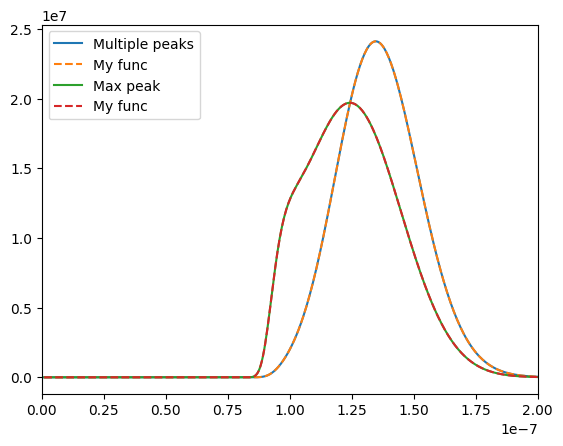

In [121]:
pks = get_signal_peaks(signal, 5e-8)

signal_pdf, signal_cdf = calculate_signal_dists(threshold, tau_1f, 0, pks, Nsamp)


rice_cdf = np.ones(20001)
for peak in pks:
    rice_cdf *= scipy.stats.rice.cdf(x, b=abs(peak)/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)

signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Multiple peaks')

cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')


rice_cdf = np.ones(20001)
rice_cdf *= scipy.stats.rice.cdf(x, b=abs(np.max(pks))/np.sqrt(tau_1f/2), loc=0, scale=np.sqrt(tau_1f/2))
signal_cdf = rice_cdf * (1-np.exp(-(x**2)/tau_1f)) ** (Nsamp-pks.size)
signal_pdf = np.gradient(signal_cdf, x[1]-x[0])

plt.plot(x, signal_pdf, label='Max peak')

cdf, pdf = get_dists(np.array([abs(np.max(pks))]), x, tau_1f, Nsamp)

plt.plot(x, pdf, label='My func', linestyle='--')

plt.xlim(0, 0.2e-6)
plt.legend()

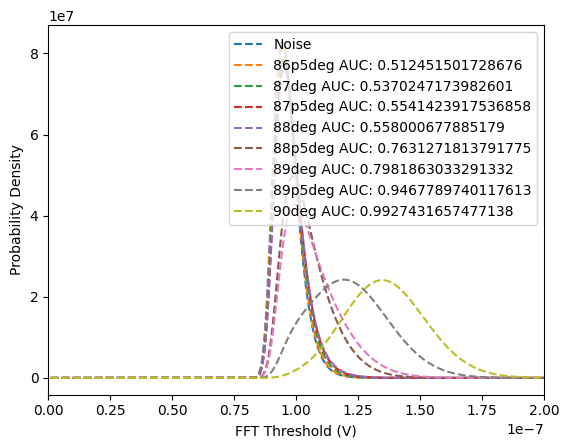

In [4]:
noise_cdf, noise_pdf = get_dists([], x, tau_1f, Nsamp)

def get_roc(noise_cdf, signal_cdf):
    fpr = 1 - noise_cdf
    tpr = 1 - signal_cdf
    
    return fpr, tpr

    
plt.plot(x, noise_pdf, label='Noise', linestyle='--')


for filename in file_list:
    
    signal = get_signal(filename, 'signal1') # One polarisation

    pks = get_signal_peaks(signal, 1e-9)
    cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)
    
    fpr,tpr = get_roc(noise_cdf, cdf)
    auc = abs(np.trapz(tpr, fpr))
    
    
    label = filename.split('/')[1].split('.')[0] + ' AUC: ' + str(auc)
    
    # plt.text(0.1e-6, 0.1e6, str(label) + ' AUC: ' + str(auc))

    
    plt.plot(x, pdf, label=label, linestyle='--')

    plt.xlim(0, 0.2e-6)

plt.xlabel('FFT Threshold (V)')
plt.ylabel('Probability Density')

plt.legend()

plt.savefig('harmonic_dists.png')

plt.show(  )


In [130]:
df = pd.read_csv('../data/simulations_truth/harmonic.csv')


# sort the dataframe by angle
df = df.sort_values(by='Pitch angle [degrees]')

# store File_name for specific angle

files_container = []

angles = df['Pitch angle [degrees]'].unique()

for angle in angles:
    files_container.append(df[df['Pitch angle [degrees]'] == angle]['File_name'].values)

# Provide info on files_container for each angle

print(np.shape(files_container))

(8, 100)


In [123]:
# filecontainer is a list of lists, each list contains the filenames for a specific angle
# we need a directory for each angle


def get_auc_eff(filelist, override_path=False):
    def get_efficiency(tpr, fpr, threshold):
        """Helper function to compute efficiency for a given FPR threshold."""
        ind = np.where(fpr < threshold)[0][0]
        return tpr[ind]
    


    degrees, aucs = [], []
    efficiencies = {0.1: [], 0.05: [], 0.01: []}

    for filename in filelist:
        signal = get_signal(filename, 'signal1', full_path=False, override_path=override_path)  # One polarisation
        pks = get_signal_peaks(signal, 1e-9)
        cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

        fpr, tpr = get_roc(noise_cdf, cdf)
        aucs.append(abs(np.trapz(tpr, fpr)))

        for threshold in efficiencies:
            efficiencies[threshold].append(get_efficiency(tpr, fpr, threshold))

        degrees.append(override_path.split('/')[-2])

    return degrees, aucs, efficiencies[0.1], efficiencies[0.05], efficiencies[0.01]

angle_dir = ['86.5deg', '87.0deg', '87.5deg', '88.0deg', '88.5deg', '89.0deg', '89.5deg', '90.0deg']

degrees = []
aucs = []
efficiencies10 = []
efficiencies5 = []
efficiencies1 = []



for i in range(len(files_container)):

    override_path = '../../../../Desktop/v2/Harmonic/' + angle_dir[i] + '/'


    degrees_temp, aucs_temp, efficiencies10_temp, efficiencies5_temp, efficiencies1_temp = get_auc_eff(files_container[i], override_path=override_path)
    
    degrees.append(degrees_temp)
    aucs.append(aucs_temp)
    efficiencies10.append(efficiencies10_temp)
    efficiencies5.append(efficiencies5_temp)
    efficiencies1.append(efficiencies1_temp)


In [124]:
pd.DataFrame(degrees).to_csv('../data/analysis/degrees.csv')
pd.DataFrame(aucs).to_csv('../data/analysis/aucs.csv')
pd.DataFrame(efficiencies10).to_csv('../data/analysis/efficiencies10.csv')
pd.DataFrame(efficiencies5).to_csv('../data/analysis/efficiencies5.csv')
pd.DataFrame(efficiencies1).to_csv('../data/analysis/efficiencies1.csv')


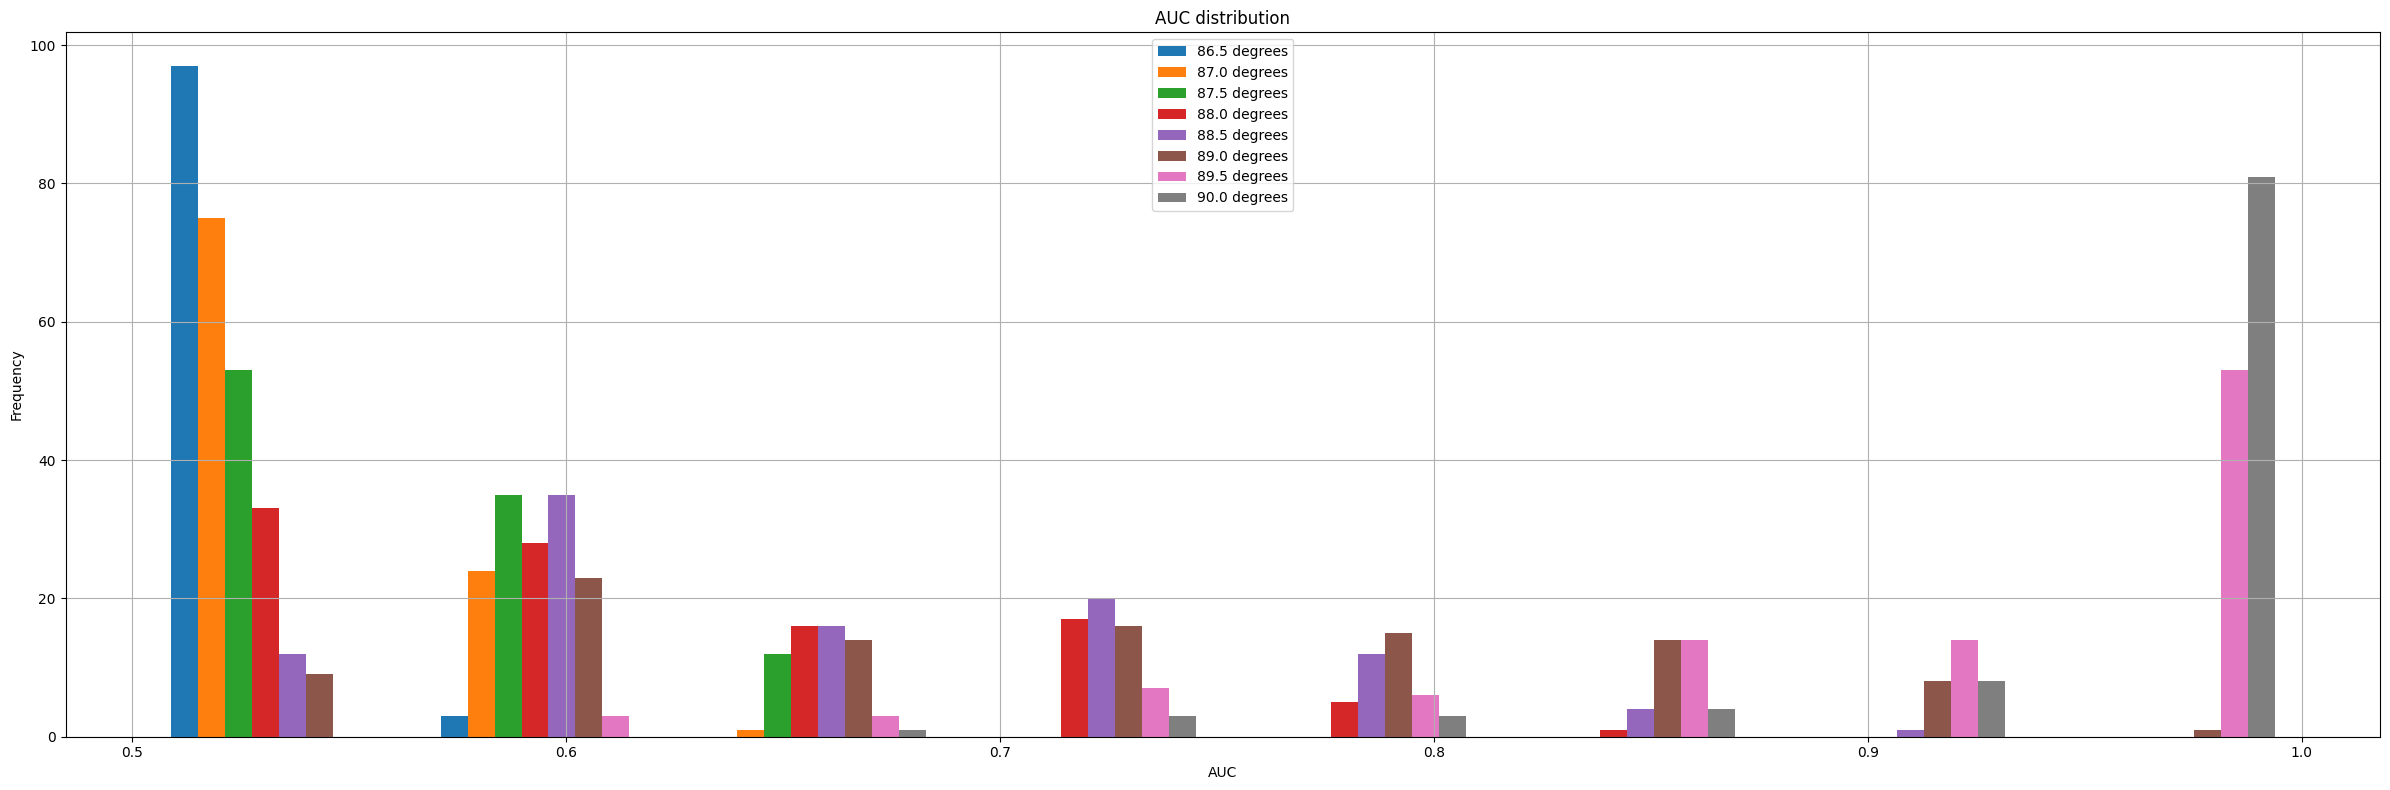

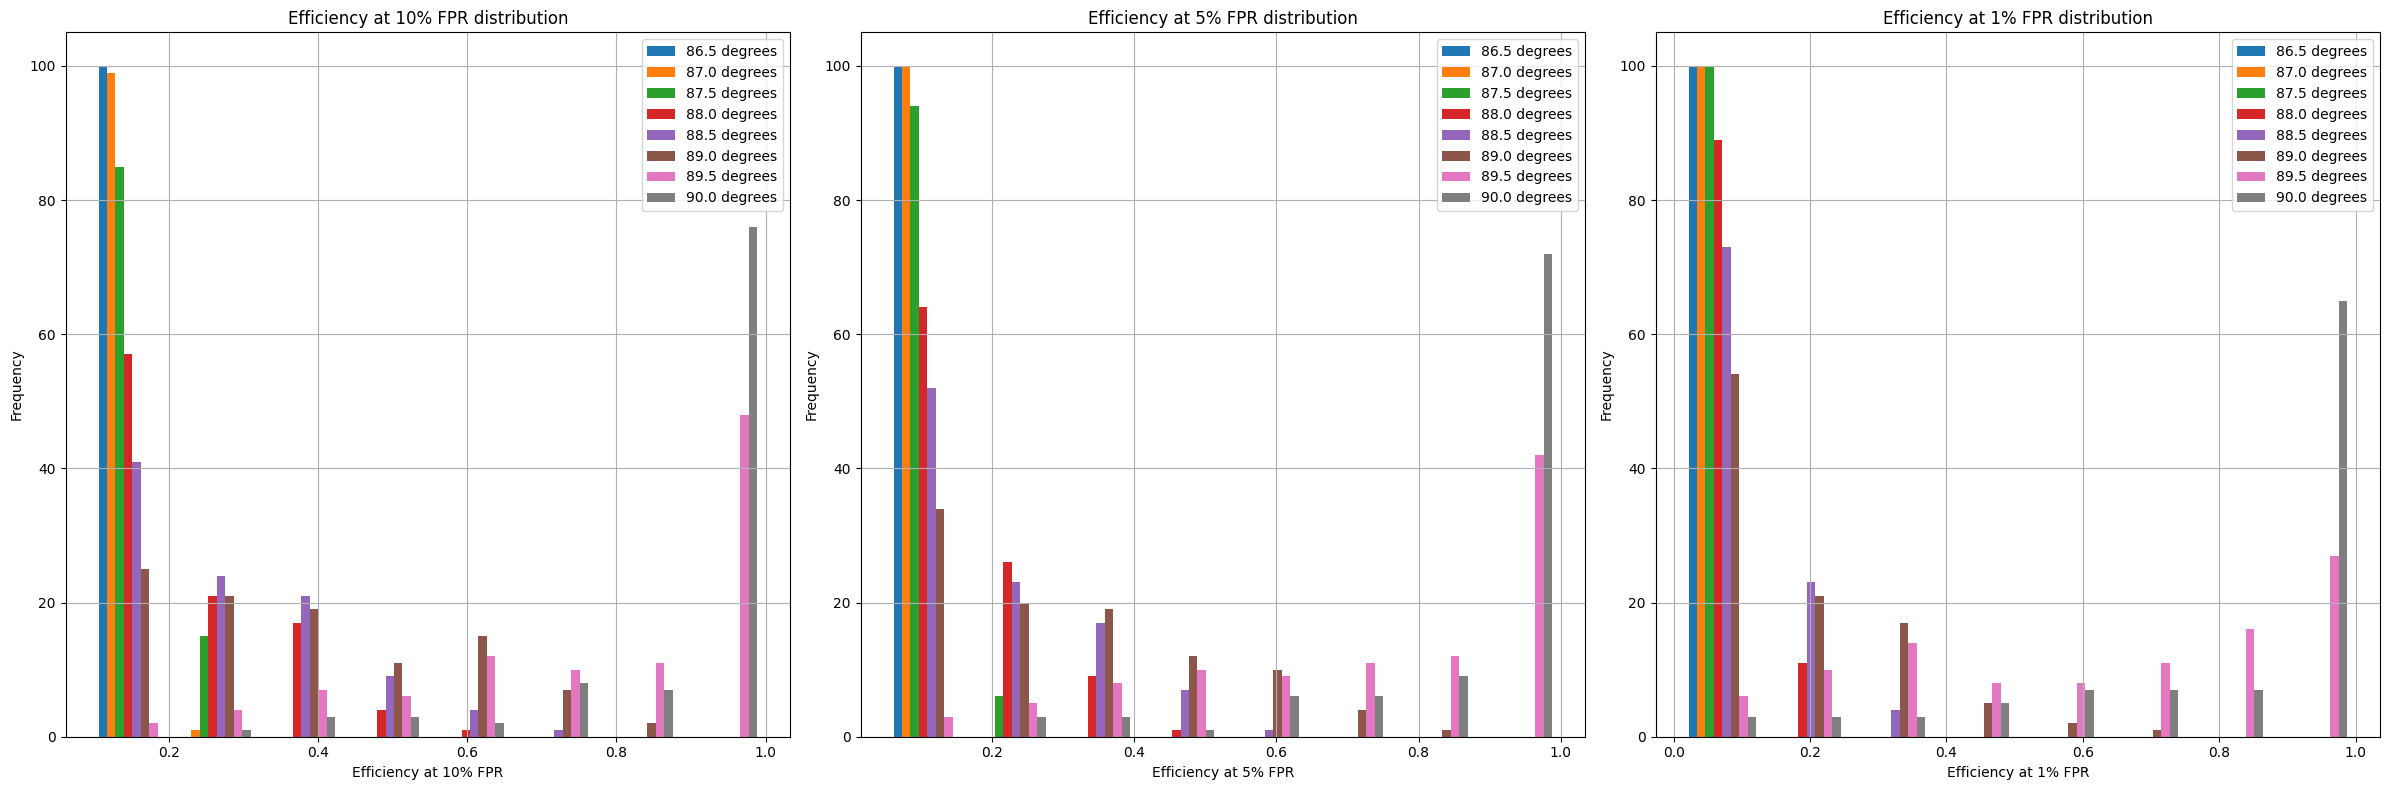

In [125]:
# plotting for 90 degree electrons 

labels = [str(degree) + ' degrees' for degree in df['Pitch angle [degrees]'].unique()]


fig, ax1 = plt.subplots(1, 1, figsize=(24, 8))


ax1.hist(aucs, bins=8)
ax1.set_xlabel('AUC')
ax1.set_ylabel('Frequency')
ax1.set_title('AUC distribution')

ax1.legend(labels)


plt.tight_layout()
plt.grid(True)

plt.savefig('../figures/harmonic_auc.png')
plt.show()


fig, ax1 = plt.subplots(1, 3, figsize=(24, 8))


ax1[0].hist(efficiencies10, bins=8)
ax1[0].set_xlabel('Efficiency at 10% FPR')
ax1[0].set_ylabel('Frequency')
ax1[0].set_title('Efficiency at 10% FPR distribution')
ax1[0].grid(True)

ax1[1].hist(efficiencies5, bins=8)
ax1[1].set_xlabel('Efficiency at 5% FPR')
ax1[1].set_ylabel('Frequency')
ax1[1].set_title('Efficiency at 5% FPR distribution')
ax1[1].grid(True)

ax1[2].hist(efficiencies1, bins=8)
ax1[2].set_xlabel('Efficiency at 1% FPR')
ax1[2].set_ylabel('Frequency')
ax1[2].set_title('Efficiency at 1% FPR distribution')
ax1[2].grid(True)

# create labels for a legend 

ax1[0].legend(labels)
ax1[1].legend(labels)
ax1[2].legend(labels)

plt.tight_layout()

plt.savefig('../figures/harmonic_efficiencies.png')

plt.show()



In [ ]:
# Return value from 'Starting position [metres]' column of dataframe

print(files_container[i][0])

# df['out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5']


out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5


,File_name,signal,trap,B_bkg [Tesla],Cyclotron frequency [Hertz],Downmixed cyclotron frequency [Hertz],Energy [eV],LO frequency [Hertz],Pitch angle [degrees],Starting position [metres],Starting velocity [metres/second],Time step [seconds],Waveguide impedance [Ohms],i_coil [Amps],r_coil [metres],r_wg [metres]
649,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.895685e+10,2.075588e+08,18575.0,1.874929e+10,86.5,[ 0.00224972 -0.00030075 0. ],[78323096.11062804 6055430.07081304 4804741....,1.000000e-09,593.112775,108.225361,0.02,0.006
671,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.895735e+10,2.080604e+08,18575.0,1.874929e+10,86.5,[-0.00253532 0.00052861 0. ],[44386268.90985302 64815389.76168698 -4804741....,1.000000e-09,593.089576,108.225361,0.02,0.006
670,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.895592e+10,2.066386e+08,18575.0,1.874929e+10,86.5,[0.00346636 0.00120644 0. ],[ 67483371.01514591 -40214055.43002778 -48047...,1.000000e-09,593.155355,108.225361,0.02,0.006
669,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.895802e+10,2.087303e+08,18575.0,1.874929e+10,86.5,[-0.0006568 0.0008032 0. ],[ 52460860.7713789 -58472503.83576182 48047...,1.000000e-09,593.058592,108.225361,0.02,0.006
668,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.895503e+10,2.057393e+08,18575.0,1.874929e+10,86.5,[ 0.00106274 -0.00306192 0. ],[78552680.2473301 -807492.20299491 -4804741....,1.000000e-09,593.196984,108.225361,0.02,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.890607e+10,1.567872e+08,18575.0,1.874929e+10,90.0,[-0.00226098 -0.00085626 0. ],[ 7.86813117e+07 -1.87412756e+06 4.81920734e-09],1.000000e-09,595.485251,108.225361,0.02,0.006
472,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.890404e+10,1.547528e+08,18575.0,1.874929e+10,90.0,[0.00059943 0.00361184 0. ],[-7.85794464e+07 4.41947528e+06 -4.81920734e-09],1.000000e-09,595.581313,108.225361,0.02,0.006
473,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.890415e+10,1.548676e+08,18575.0,1.874929e+10,90.0,[ 0.00199572 -0.00311504 0. ],[ 7.84505776e+07 -6.30619003e+06 -4.81920734e-09],1.000000e-09,595.575887,108.225361,0.02,0.006
463,out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5,signal1,Harmonic,0.7034,1.890604e+10,1.567581e+08,18575.0,1.874929e+10,90.0,[-0.00185466 -0.00115855 0. ],[ 7.03724339e+07 -3.52417608e+07 -4.81920734e-09],1.000000e-09,595.486626,108.225361,0.02,0.006


In [131]:
# Pull out the radii for each event from the data frame and store them 
import re

radii_magnitude_container = []





for i in range(len(files_container)):
    radii = []
    for filename in files_container[i]:

        rad_x = df.loc[df['File_name'] == filename]['Starting x position [metres]']
        rad_y = df.loc[df['File_name'] == filename]['Starting x position [metres]']
        rad_z = df.loc[df['File_name'] == filename]['Starting x position [metres]']



        radius_magnitude = np.linalg.norm([rad_x, rad_y, rad_z])    

        radii.append(radius_magnitude)
    radii_magnitude_container.append(radii)


pd.DataFrame(radii_magnitude_container).to_csv('../data/analysis/radii_magnitudes.csv')



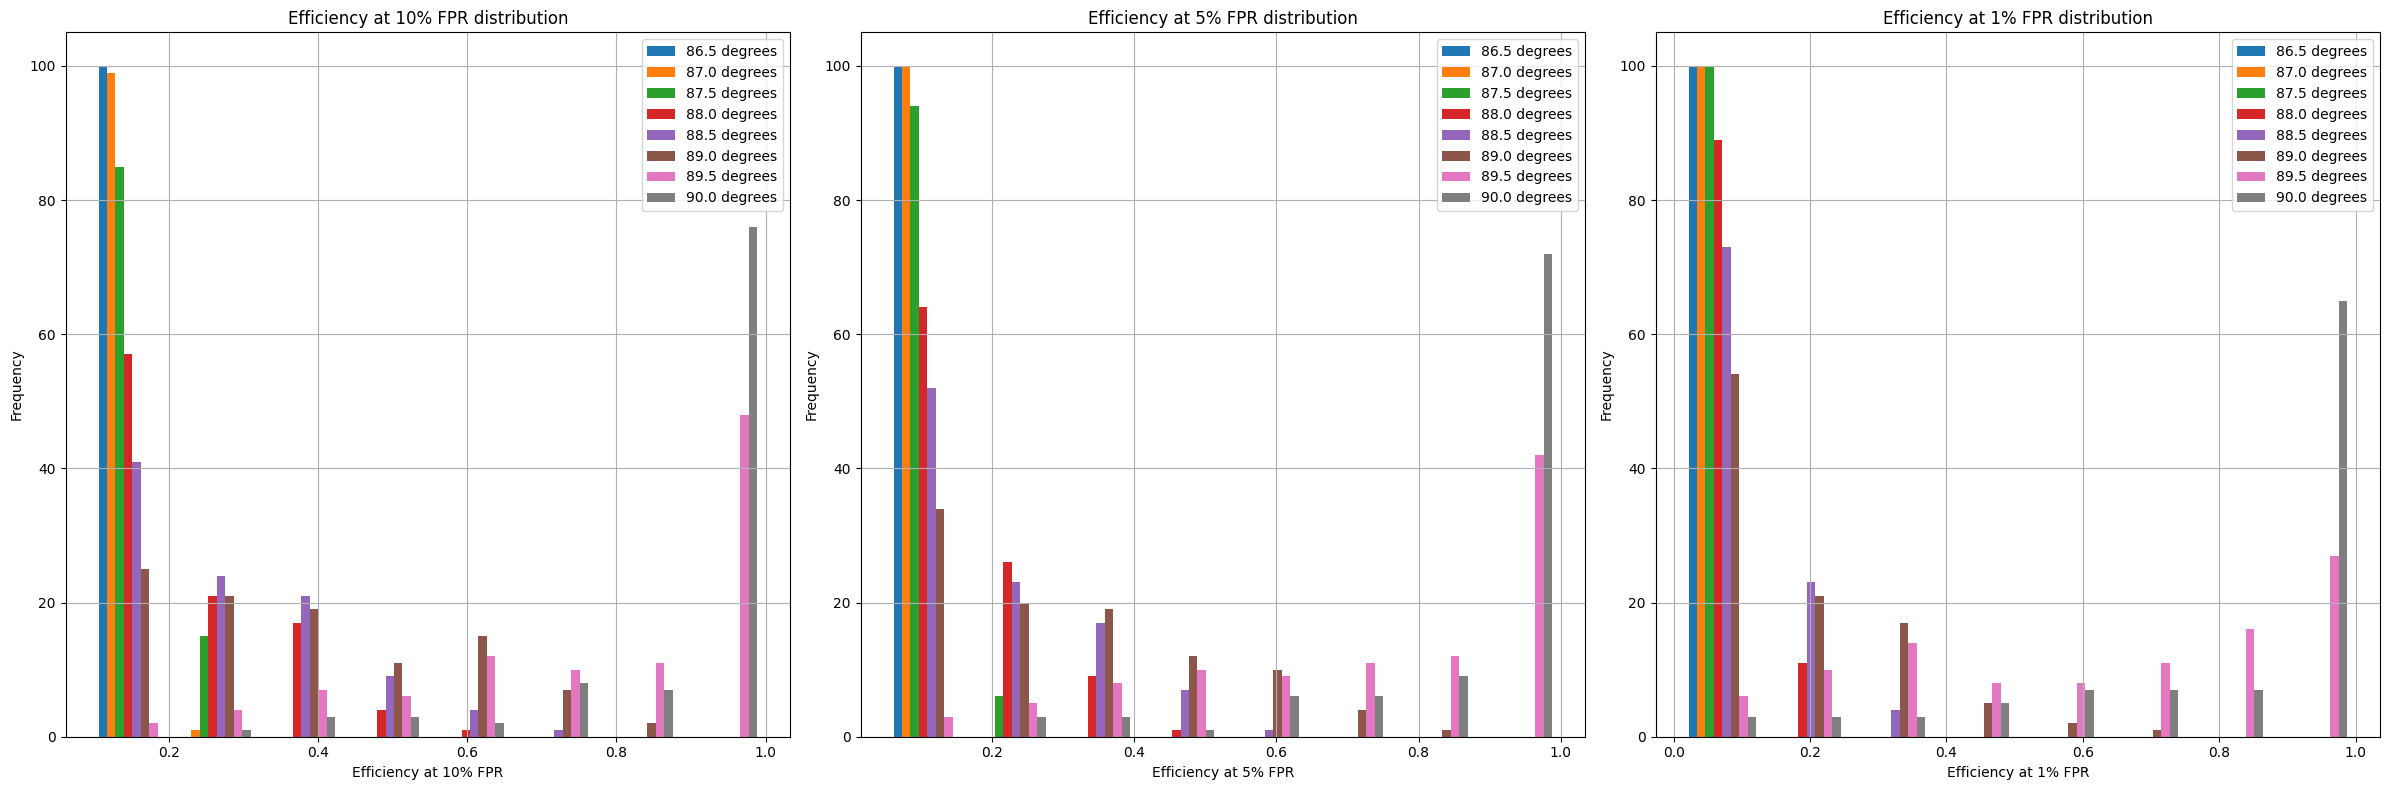

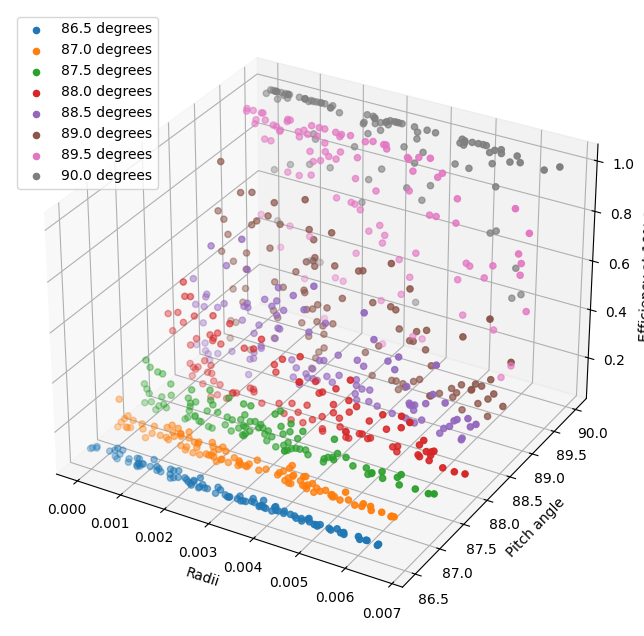

In [152]:

true_angles = df['Pitch angle [degrees]'].values

fig, ax1 = plt.subplots(1, 3, figsize=(24, 8))


ax1[0].hist(efficiencies10, bins=8)
ax1[0].set_xlabel('Efficiency at 10% FPR')
ax1[0].set_ylabel('Frequency')
ax1[0].set_title('Efficiency at 10% FPR distribution')
ax1[0].grid(True)

ax1[1].hist(efficiencies5, bins=8)
ax1[1].set_xlabel('Efficiency at 5% FPR')
ax1[1].set_ylabel('Frequency')
ax1[1].set_title('Efficiency at 5% FPR distribution')
ax1[1].grid(True)

ax1[2].hist(efficiencies1, bins=8)
ax1[2].set_xlabel('Efficiency at 1% FPR')
ax1[2].set_ylabel('Frequency')
ax1[2].set_title('Efficiency at 1% FPR distribution')
ax1[2].grid(True)

# create labels for a legend 

ax1[0].legend(labels)
ax1[1].legend(labels)
ax1[2].legend(labels)

plt.tight_layout()

plt.savefig('../figures/harmonic_efficiencies.png')

plt.show()

# Replicate the above plot but let us plot the radii and pitch angle on a 3d plot and the efficiency will be a Z value or a colour map

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(radii_magnitude_container)):
    ax.scatter(radii_magnitude_container[i], angles[i], efficiencies10[i], label=labels[i])

ax.set_xlabel('Radii')
ax.set_ylabel('Pitch angle')
ax.set_zlabel('Efficiency at 10% FPR')

plt.legend()
plt.show()

### Replicate the above plot but do it with plotly so it is interactive

import plotly.express as px

fig = px.scatter_3d(x=np.reshape(radii_magnitude_container, -1), y=true_angles, z=np.reshape(efficiencies10,-1))

fig.write_html("../figures/plot.html")
fig.show()




# # Let us plot the same data but with a colour map on a 2d plot

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# for i in range(len(radii_magnitude_container)):
#     sc = ax.scatter(radii_magnitude_container[i], [angles[i]]*len(radii_magnitude_container[i]), c=efficiencies10[i], label=labels[i])

# plt.colorbar(sc)
# plt.show()


[86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5 86.5
 86.5 86.5 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.  87.
 87.  87.  87

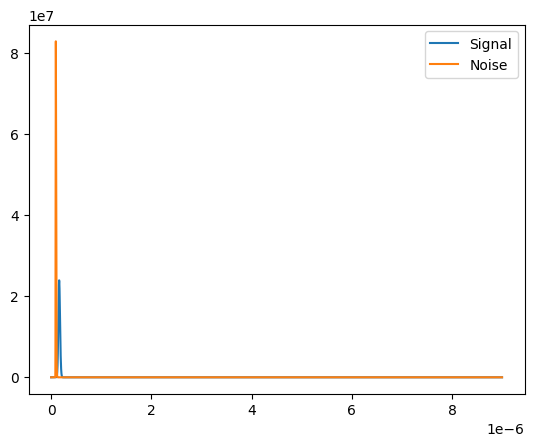

0.9999022610527654
0.9997951943432187
0.999055952173791


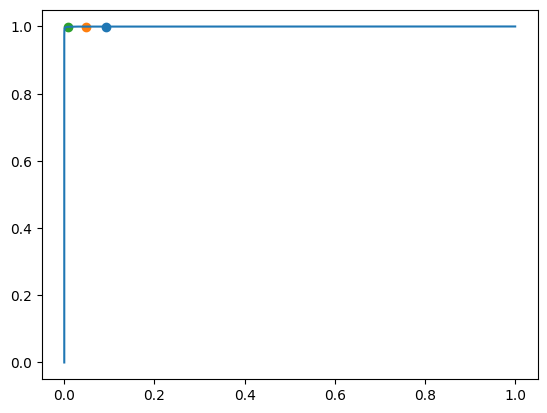

In [ ]:
listoffiles = glob.glob(path_to_all)
test = listoffiles[348]

signal = get_signal(test, 'signal1') # One polarisation

pks = get_signal_peaks(signal, 1e-9)
cdf, pdf = get_dists(pks, x, tau_1f, Nsamp)

fpr,tpr = get_roc(noise_cdf, cdf)

plt.plot(x, pdf, label='Signal')
plt.plot(x, noise_pdf, label='Noise')
plt.legend()
plt.show()



plt.plot(fpr, tpr, label='ROC curve')

ind = np.where(fpr < 0.1)[0][0]

print(tpr[ind])


plt.scatter(fpr[ind], tpr[ind], label='10$\%$ FPR')

ind = np.where(fpr < 0.05)[0][0]
print(tpr[ind])

plt.scatter(fpr[ind], tpr[ind], label='5$\%$ FPR')

ind = np.where(fpr < 0.01)[0][0]
print(tpr[ind])

plt.scatter(fpr[ind], tpr[ind], label='1$\%$ FPR')

plt.show()




In [ ]:
ind = np.where(fpr < 0.1)[0][0]

tpr[ind]



0.9808755912355127

In [ ]:
print(fpr)

[1. 1. 1. ... 0. 0. 0.]


In [ ]:
savefile = '../data/simulations_truth/harmonic.csv'

import pandas as pd

pd.read_csv(savefile)

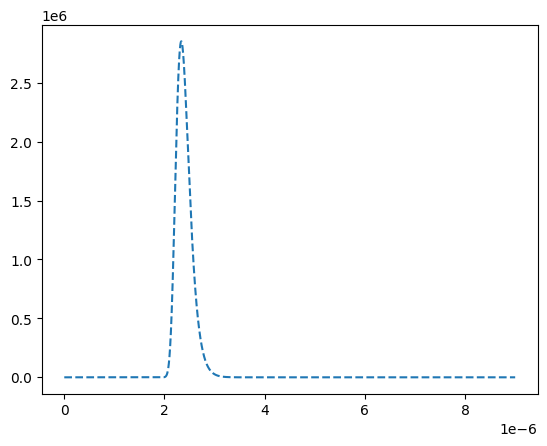

In [71]:
R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 200e6, 8192, 60

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t * 60 / Nsamp # noise variance single channel, freq-domain (tau_1f)

noise_cdf, noise_pdf = get_dists([], x, tau_1f, Nsamp)

plt.plot(x, noise_pdf, label='Noise', linestyle='--')
# plt.xlim(2e-7, 5e-7)
# plt.xlim(0.1e-6, 2e-6)